In [1]:
import os
import sys
from importlib import reload
module_paths = [
    os.path.abspath(os.path.join('..')),
]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)
        
import torch
from time import time 
import csv

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.model_selection import train_test_split

import aav
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 16

import seaborn as sns
sns.set_style('darkgrid')

2024-02-20 18:49:38.573641: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 18:49:38.573683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 18:49:38.574885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 18:49:38.582016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 18:49:40.576442: W tensorflow/comp

seq_n (8552729,)
ohe_nxla (8552729, 147)
y_nx2 (8552729, 2)


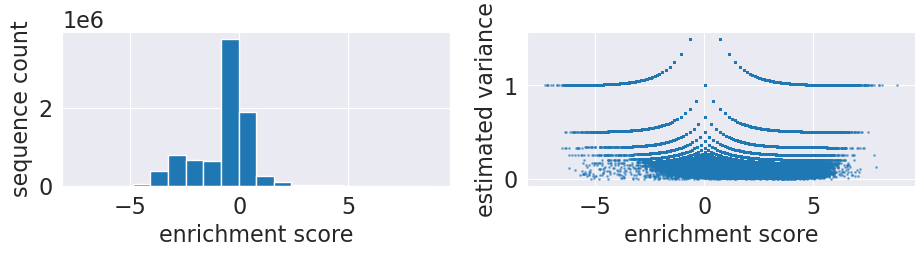

In [2]:
d = np.load('../aav-data.npz')
for thing in d:
    print(thing, d[thing].shape)
seq_n = list(d['seq_n'])
ohe_nxla = d['ohe_nxla']
y_nx2 = d['y_nx2']

plt.figure(figsize=(11, 2))
plt.subplot(121)
plt.hist(y_nx2[:, 0], bins=20);
plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.subplot(122)
plt.scatter(y_nx2[:, 0], y_nx2[:, 1], s=1, alpha=0.5);
plt.xlabel('enrichment score');
plt.ylabel('estimated variance');

In [11]:
# generate training and test data
reload(aav)
# train_idx, test_idx = train_test_split(range(len(seq_n)), test_size=0.2, random_state=1234)
idx = np.random.choice(len(seq_n), 1000000)
# train_idx = np.copy(idx)
train_idx, test_idx = idx[: 999000], idx[999000 :]

trainseq_n = [seq_n[i] for i in train_idx]
ytrain_nx2 = y_nx2[train_idx]
testseq_n = [seq_n[i] for i in test_idx]
ytest_nx2 = y_nx2[test_idx]

In [4]:
from sklearn.neighbors import KNeighborsRegressor

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc7f941b060>
Traceback (most recent call last):
  File "/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = ge

Done training (0 s)
Done predicting (149 s)


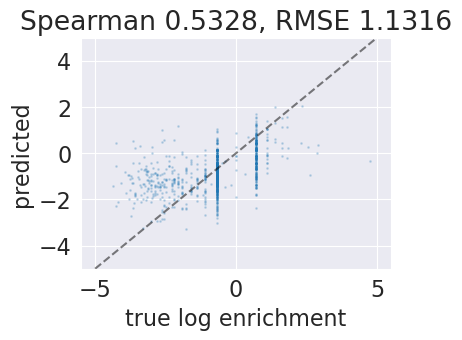

In [13]:
# train kNN model
trainohe_nxla = ohe_nxla[train_idx]
testohe_nxla = ohe_nxla[test_idx]

knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='cityblock')
t0 = time()
knn.fit(trainohe_nxla, ytrain_nx2[:, 0])
print('Done training ({} s)'.format(int(time() - t0)))
t0 = time()
pred_n = knn.predict(testohe_nxla)
print('Done predicting ({} s)'.format(int(time() - t0)))

plt.figure(figsize=(4, 3))
plt.scatter(ytest_nx2[:, 0], pred_n, alpha=0.2, s=1);
plt.plot([-5, 5], [-5, 5], '--k', alpha=0.5)
rho, p = sc.stats.spearmanr(ytest_nx2[:, 0], pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_nx2[:, 0] - pred_n)))

plt.ylim([-5, 5]);
plt.title('Spearman {:.4f}, RMSE {:.4f}'.format(rho, rmse));
plt.xlabel('true log enrichment'); plt.ylabel('predicted');

In [15]:
# train NN model
reload(aav)
n_epoch = 5
n_hidden = 100
n_model = 3
batch_size = 64
n_data_workers = 1
device = torch.device(0)

model = aav.EnrichmentFeedForward(
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
loss_tx2 = model.fit(
    ohe_nxla[train_idx],
    ytrain_nx2,
    batch_size=batch_size,
    n_epoch=n_epoch,
    n_data_workers=n_data_workers
)

Sequences are already one-hot encoded.
90000 training data points, 10000 validation data points.


100%|███████████████████████████████████████████| 1407/1407 [00:06<00:00, 229.82it/s]


Epoch 0. Train loss: 1.571125. Val loss: 1.64. 7 sec.


100%|███████████████████████████████████████████| 1407/1407 [00:06<00:00, 224.00it/s]


Epoch 1. Train loss: 1.028318. Val loss: 1.06. 7 sec.


100%|███████████████████████████████████████████| 1407/1407 [00:06<00:00, 223.12it/s]


Epoch 2. Train loss: 0.896183. Val loss: 1.07. 7 sec.


100%|███████████████████████████████████████████| 1407/1407 [00:06<00:00, 223.38it/s]


Epoch 3. Train loss: 0.853752. Val loss: 1.03. 7 sec.


100%|███████████████████████████████████████████| 1407/1407 [00:06<00:00, 223.57it/s]

Epoch 4. Train loss: 0.973980. Val loss: 1.06. 7 sec.


In [42]:
model.save('/homefs/home/wongfanc/density-ratio-estimation/aav-models/021423-100k.pt')

Saved models to /homefs/home/wongfanc/density-ratio-estimation/aav-models/021423-100k.pt.


In [ ]:
pred_n = model.predict(ohe_nxla[test_idx])

plt.figure(figsize=(4, 3))
plt.scatter(ytest_nx2[:, 0], pred_n, alpha=0.2, s=1);
plt.plot([-5, 5], [-5, 5], '--k', alpha=0.5)
rho, p = sc.stats.spearmanr(ytest_nx2[:, 0], pred_n)
rmse = np.sqrt(np.mean(np.square(ytest_nx2[:, 0] - pred_n)))

plt.ylim([-5, 5]);
plt.title('Spearman {:.4f}, RMSE {:.4f}'.format(rho, rmse));
plt.xlabel('true log enrichment'); plt.ylabel('predicted');

In [3]:
# load model
reload(aav)
n_hidden = 100
n_model = 3
device = torch.device(0)

model = aav.EnrichmentFeedForward(
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('021423-100k')

# optimization of theta

In [45]:
reload(aav)
temperatures = 1 / np.arange(0.5, 8.1, 0.5)
lr = 0.01
n_sample = 1000
n_iter = 2000

for temp in temperatures:
    print('Temperature = {:.4f}'.format(temp))
    save_fname_no_ftype = 't{:.4f}-021423-100k'.format(temp)
    
    t0 = time()
    theta_lxa, df = aav.solve_max_entropy_library(
        model,
        temperature=temp,
        lr=lr,
        n_sample=n_sample,
        n_iter=n_iter,
        save_fname_no_ftype=save_fname_no_ftype
    )
    print('{} sec'.format(int(time() - t0)))
    print()

Temperature = 2.0000
Iter: 1. Objective: 48.75. Mean prediction: -0.51. Entropy: 24.63. EPD: 6.11
Iter: 500. Objective: 57.75. Mean prediction: 0.10. Entropy: 28.82. EPD: 6.57
Iter: 1000. Objective: 58.04. Mean prediction: 0.15. Entropy: 28.95. EPD: 6.56
Iter: 1500. Objective: 58.06. Mean prediction: 0.10. Entropy: 28.98. EPD: 6.58
Iter: 2000. Objective: 58.07. Mean prediction: 0.21. Entropy: 28.93. EPD: 6.57
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/t2.0000-021423-100k.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/t2.0000-021423-100k.csv
119 sec

Temperature = 1.0000
Iter: 1. Objective: 24.25. Mean prediction: -0.40. Entropy: 24.65. EPD: 6.17
Iter: 500. Objective: 28.43. Mean prediction: 0.47. Entropy: 27.96. EPD: 6.49
Iter: 1000. Objective: 29.05. Mean prediction: 0.62. Entropy: 28.43. EPD: 6.53
Iter: 1500. Objective: 29.21. Mean prediction: 0.73. Entropy: 28.49. EPD: 6.52
Iter: 2000. Object

Iter: 500. Objective: 3.73. Mean prediction: 0.27. Entropy: 24.24. EPD: 6.14
Iter: 1000. Objective: 4.47. Mean prediction: 0.99. Entropy: 24.35. EPD: 6.12
Iter: 1500. Objective: 5.17. Mean prediction: 1.75. Entropy: 23.93. EPD: 5.99
Iter: 2000. Objective: 5.77. Mean prediction: 2.46. Entropy: 23.17. EPD: 5.82
Saved parameters to:           /homefs/home/wongfanc/density-ratio-estimation/aav-models/t0.1429-021423-100k.npz
Saved optimization metrics to: /homefs/home/wongfanc/density-ratio-estimation/aav-models/t0.1429-021423-100k.csv
119 sec

Temperature = 0.1333
Iter: 1. Objective: 3.62. Mean prediction: 0.36. Entropy: 24.47. EPD: 6.23
Iter: 500. Objective: 4.59. Mean prediction: 1.43. Entropy: 23.68. EPD: 5.98
Iter: 1000. Objective: 5.37. Mean prediction: 2.41. Entropy: 22.23. EPD: 5.57
Iter: 1500. Objective: 5.98. Mean prediction: 3.18. Entropy: 20.99. EPD: 5.19
Iter: 2000. Objective: 6.37. Mean prediction: 3.73. Entropy: 19.82. EPD: 4.76
Saved parameters to:           /homefs/home/won

In [144]:
cal_idx = np.delete(np.arange(len(seq_n)), idx)
print(cal_idx.size)
calseq_n = [seq_n[i] for i in cal_idx]
ycal_nx2 = y_nx2[cal_idx]

8453342


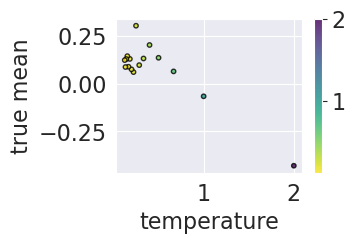

In [102]:
plt.figure(figsize=(3, 2))
truemeans_t = [temp2mean[temp] for temp in temperatures]
plt.scatter(temperatures, truemeans_t, edgecolors='k', s=10, alpha=0.8, c=temperatures, cmap='viridis_r')
plt.colorbar()
plt.xlabel('temperature');
plt.ylabel('true mean');
plt.xticks();

In [47]:
reload(aav)

labels_t = []
preds_t = []
nsamp_t = []

for temp in temperatures:
    d = np.load('/homefs/home/wongfanc/density-ratio-estimation/aav-models/t{:.4f}-021423-100k.npz'.format(temp))
    theta_lxa = d['theta_lxa']
    
    # rejection-sample from design distribution
    paccept_n = aav.get_rejection_sampling_acceptance_probabilities(calseq_n, theta_lxa)
    testsamp_idx = aav.rejection_sample_from_test_distribution(paccept_n)
    nsamp_t.append(testsamp_idx.size)
    print('Temp: {:.2f}. Median acceptance prob.: {:.6f}. Number of test samples: {}.'.format(
        temp, np.median(paccept_n), testsamp_idx.size
    ))
    testseq_n = [calseq_n[i] for i in testsamp_idx]
    
    # report mean label and mean prediction
    labels_t.append(ycal_nx2[testsamp_idx, 0])
    pred_n = model.predict(testseq_n, verbose=False)
    preds_t.append(pred_n)
    print('    Mean prediction: {:.2f}. Mean true label: {:.2f}'.format(
        np.mean(pred_n), np.mean(labels_t[-1])
    ))

Temp: 2.00. Median acceptance prob.: 0.037197. Number of test samples: 406265.
Done, shape = (406265, 147) (1 sec)
    Mean prediction: -0.14. Mean true label: -0.44
Temp: 1.00. Median acceptance prob.: 0.004027. Number of test samples: 70694.
Done, shape = (70694, 147) (0 sec)
    Mean prediction: 0.41. Mean true label: -0.10
Temp: 0.67. Median acceptance prob.: 0.000191. Number of test samples: 6381.
Done, shape = (6381, 147) (0 sec)
    Mean prediction: 0.87. Mean true label: 0.13
Temp: 0.50. Median acceptance prob.: 0.000004. Number of test samples: 559.
Done, shape = (559, 147) (0 sec)
    Mean prediction: 1.36. Mean true label: 0.38
Temp: 0.40. Median acceptance prob.: 0.000000. Number of test samples: 126.
Done, shape = (126, 147) (0 sec)
    Mean prediction: 2.11. Mean true label: 0.80
Temp: 0.33. Median acceptance prob.: 0.000000. Number of test samples: 68.
Done, shape = (68, 147) (0 sec)
    Mean prediction: 1.74. Mean true label: 0.31
Temp: 0.29. Median acceptance prob.: 0.

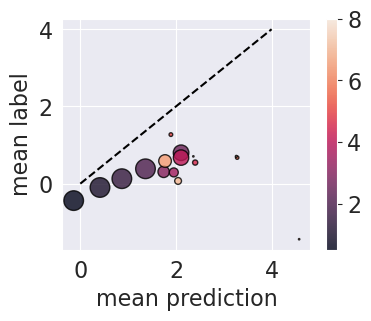

In [54]:
plt.figure(figsize=(4, 3))
plt.scatter(
    [np.mean(preds) for preds in preds_t], [np.mean(labels) for labels in labels_t],
    c=1 / temperatures,
    linewidth=1,
    edgecolors='k',
    s=np.fmin(nsamp_t, 200),
    alpha=0.8,
);
plt.colorbar()
plt.plot([0, 4], [0, 4], '--k')
# plt.xticks(np.arange(0, 2.1, 0.5))
plt.xlabel('mean prediction');
plt.ylabel('mean label');

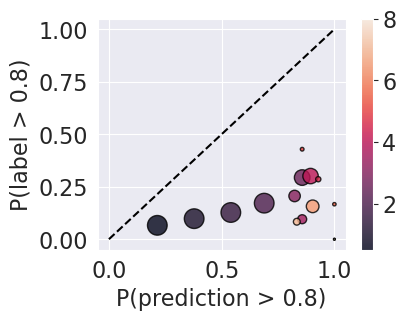

In [62]:
threshold = 0.8
plt.figure(figsize=(4, 3))
plt.scatter(
    [np.mean(preds > threshold) for preds in preds_t], [np.mean(labels > threshold) for labels in labels_t],
    c=1 / temperatures,
    linewidth=1,
    edgecolors='k',
    s=np.fmin(nsamp_t, 200),
    alpha=0.8,
);
plt.colorbar()
plt.plot([0, 1], [0, 1], '--k')
# plt.xticks(np.arange(0, 2.1, 0.5))
plt.xlabel('P(prediction > {})'.format(threshold));
plt.ylabel('P(label > {})'.format(threshold));


# run selection experiments

In [7]:
reload(aav)
PATH = '/homefs/home/wongfanc/density-ratio-estimation/aav-models/'
temperatures = 1 / np.arange(0.5, 8.1, 0.5)
temp2theta = {
    temp: np.load(PATH + 't{:.4f}-021423-100k.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
temp2mean = aav.get_true_means_from_theta(temp2theta, seq_n, y_nx2[:, 0])
# d = np.load('../temp2mean-021623.npz', allow_pickle=True)
# temp2mean = d['temp2mean'].item()

One-hot encoding validation sequences...
Done (36 sec)
True mean for temperature...
    2.0000 is -0.4302, ESS = 5195675. (4 sec)
    1.0000 is -0.0662, ESS = 2592996. (9 sec)
    0.6667 is 0.0645, ESS = 914188. (14 sec)
    0.5000 is 0.1361, ESS = 72902. (19 sec)
    0.4000 is 0.2028, ESS = 12438. (24 sec)
    0.3333 is 0.1320, ESS = 14988. (29 sec)
    0.2857 is 0.0973, ESS = 10126. (34 sec)
    0.2500 is 0.3040, ESS = 12419. (39 sec)
    0.2222 is 0.0607, ESS = 3798. (44 sec)
    0.2000 is 0.0749, ESS = 1427. (50 sec)
    0.1818 is 0.1304, ESS = 913. (55 sec)
    0.1667 is 0.0885, ESS = 105. (60 sec)
    0.1538 is 0.1438, ESS = 8409. (65 sec)
    0.1429 is 0.1300, ESS = 3106. (70 sec)
    0.1333 is 0.0870, ESS = 45. (75 sec)
    0.1250 is 0.1232, ESS = 145. (80 sec)


In [163]:
np.savez('../temp2mean-021623.npz', temp2mean=temp2mean)

0.0006484437336527205


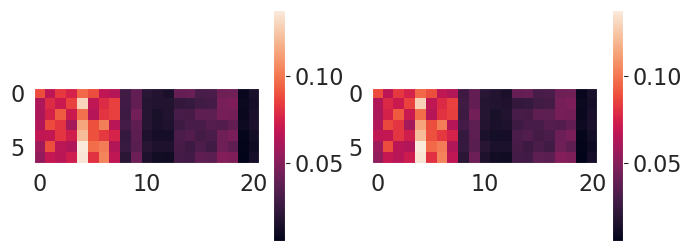

In [41]:
# sanity-check sample_ohe_from_nuc_distribution(). looks good
reload(aav)
temp = 1.0
n_design = 1000000
theta_lxa = temp2theta[temp]
_, designohe_nxlxa = aav.sample_ohe_from_nuc_distribution(theta_lxa, n_design, normalize=True)
design_fit_lxa = aav.fit_mle_paa(designohe_nxlxa)
design_true_lxa = aav.get_aa_probs_from_nuc_probs(aav.normalize_theta(theta_lxa))

print(np.max(design_fit_lxa - design_true_lxa))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(design_fit_lxa)
plt.grid(None)
plt.colorbar();
plt.subplot(122)
plt.imshow(design_true_lxa)
plt.grid(None)
plt.colorbar();

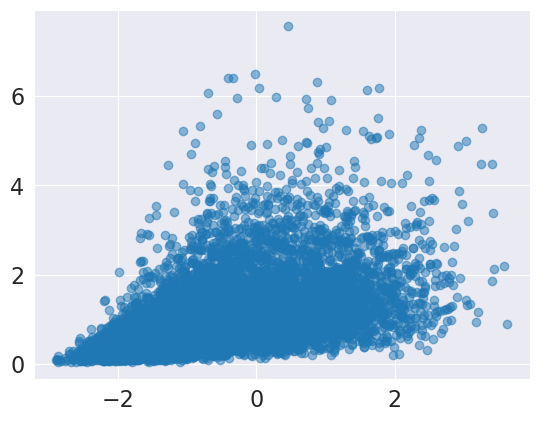

In [47]:
plt.scatter(predcal_n, caldr_n, alpha=0.5);

0.13045113656120755


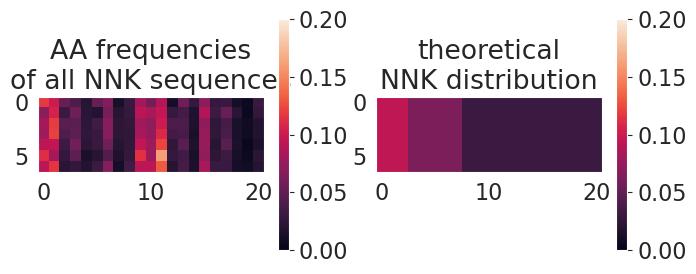

In [82]:
reload(aav)
ohe_nxlxa = np.stack([utils.str2onehot(seq, aav.AA) for seq in seq_n])

fit_lxa = aav.fit_mle_paa(ohe_nxlxa)
true_lxa = aav.PAA_NNK_LXA

print(np.max(fit_lxa - true_lxa))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(fit_lxa, vmin=0, vmax=0.2)
plt.title('AA frequencies\nof all NNK sequences')
plt.grid(None)
plt.colorbar();
plt.subplot(122)
plt.imshow(true_lxa, vmin=0, vmax=0.2)
plt.title('theoretical\nNNK distribution')
plt.grid(None)
plt.colorbar();

In [80]:
# HERE: debug, PP results should be able to ace.
# something wrong w/ get_density_ratios() when computing rectifier
# (specifically, DR-weighting the calibration predictions)
# check OHE ordering and get_aa_probs_from_nuc_probs() in get_density_ratios()?

# sanity-checking get_density_ratios()
reload(aav)
temp = 2.0
n_design = 10000
n_cal = 10000

theta_lxa = temp2theta[temp]

cal_idx = np.random.choice(len(seq_n), n_cal, replace=False)

# sample from design distribution and get predictions
_, designohe_nxlxa = aav.sample_ohe_from_nuc_distribution(theta_lxa, n_design, normalize=True)
preddesign_n = model.predict(designohe_nxlxa)
imputed_mean = np.mean(preddesign_n)

# weight calibration data
calohe_nxlxa = np.stack([utils.str2onehot(seq_n[i], aav.AA) for i in cal_idx])
caldr_n = aav.get_density_ratios(calohe_nxlxa, theta_lxa)
# caldr_n = caldr_n / np.sum(caldr_n) * n_cal
predcal_n = model.predict(calohe_nxlxa)
iw_cal_mean = np.mean(caldr_n * predcal_n)

print(imputed_mean, iw_cal_mean)  # these should have the same mean and be roughly the same

0.21621402 -0.04859211456338239


In [95]:
reload(aav)
temps = [2.0, 1.0]
n_design = 100000

# calohe_nxlxa = np.stack([utils.str2onehot(seq, aav.AA) for seq in seq_n])
# ycal_n = y_nx2[:, 0]
callogptrain_n = aav.get_loglikelihood(calohe_nxlxa, aav.LOG_PAA_TRAIN_LXA)

for temp in temps:
    print(temp)
    theta_lxa = temp2theta[temp]
    _, designohe_nxlxa = aav.sample_ohe_from_nuc_distribution(theta_lxa, n_design, normalize=True)
    preddesign_n = model.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n)
    imputed_stderr = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
    print(imputed_mean)

    caldr_n = aav.get_density_ratios(calohe_nxlxa, theta_lxa, logptrain_n=callogptrain_n)
    # caldr_n = caldr_n / np.sum(caldr_n) * len(calseq_n)
    cal_ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))

    predcal_n = model.predict(calohe_nxlxa)

    rect_n = caldr_n * (ycal_n - predcal_n)
    rect_mean = np.mean(rect_n)
    rect_stderr = np.std(rect_n) / np.sqrt(calohe_nxlxa.shape[0])
    # print(rect_mean)
    
    print(np.mean(caldr_n * ycal_n), np.mean(caldr_n * predcal_n))

    print(temp2mean[temp], imputed_mean + rect_mean)

2.0
0.20706195
-0.050098700223634766 1.1960763024865841
-0.43017647892280925 -1.0391130563181603
1.0
0.70759416
0.4713458256436357 2.79909051729406
-0.06618425271070236 -1.620150535385164


In [157]:
reload(aav)
target_values = np.arange(0, 0.6, 0.1)
n_cal = 1000000
n_trial = 10
print_every = 1

temp_df, df = aav.run_temperature_selection_experiments(
    model,
    temp2theta,
    target_values,
    calseq_n,
    ycal_nx2[:, 0],
    n_cal=n_cal,
    n_trial=n_trial,
    print_every=print_every,
)

0 2.0 606665.7020979462
0 1.0 301504.81585158804
0 0.6666666666666666 104076.24202254423
0 0.5 9337.817355860958
0 0.4 989.0442394235786
0 0.3333333333333333 1603.4083758222605
0 0.2857142857142857 1036.2635358794023
0 0.25 1552.3947119946154
0 0.2222222222222222 867.5544250204096
0 0.2 129.46203276357943
0 0.18181818181818182 49.01770840308196
0 0.16666666666666666 16.13164430150145
0 0.15384615384615385 879.6870260669202
0 0.14285714285714285 153.41315818911744
0 0.13333333333333333 86.95358803401543
0 0.125 132.39825566986934
Done with 1 / 10 trials. 60 s
1 2.0 607558.8210592612
1 1.0 303075.13981812383
1 0.6666666666666666 107138.91998083737
1 0.5 9765.258998525325
1 0.4 1258.3185835976753
1 0.3333333333333333 2721.5403237937944
1 0.2857142857142857 1043.8924065947378
1 0.25 1633.7218031110076
1 0.2222222222222222 1137.4594153645894
1 0.2 536.5816586187308
1 0.18181818181818182 158.85679395645633
1 0.16666666666666666 9.202662365639023
1 0.15384615384615385 829.7654652007258
1 0.14

0.0
0.1
0.2
0.30000000000000004
0.4
0.5


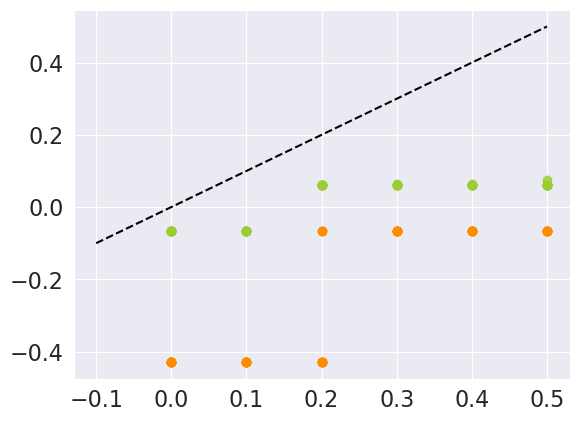

In [158]:
n_trial = 10
imp_lowest_achieved_vxt = np.empty([target_values.size, n_trial])
pp_lowest_achieved_vxt = np.empty([target_values.size, n_trial])

for iv, v in enumerate(target_values):
    print(v)
    for i in range(n_trial):
        imp_achieved_vals = []
        pp_achieved_vals = []
        for temp in temperatures:
            if df.loc[v]['tr{}_imp_selected_temp{:.4f}'.format(i, temp)]:
                imp_achieved_vals.append(temp2mean[temp])
            if df.loc[v]['tr{}_pp_selected_temp{:.4f}'.format(i, temp)]:
                pp_achieved_vals.append(temp2mean[temp])
        imp_lowest_achieved_vxt[iv, i] = np.min(imp_achieved_vals)
        pp_lowest_achieved_vxt[iv, i] = np.min(pp_achieved_vals)
        
for iv, v in enumerate(target_values):
    plt.scatter(v * np.ones([n_trial]), imp_lowest_achieved_vxt[iv, :], alpha=0.8, c='darkorange')
for iv, v in enumerate(target_values):
    plt.scatter(v * np.ones([n_trial]), pp_lowest_achieved_vxt[iv, :], alpha=0.8, c='yellowgreen')
plt.plot([-0.1, 0.5], [-0.1, 0.5], '--k');